# k-Nearest Neighbors Classification

This notebooks uses a simple kNN classifier that segmented the image detecting between damage and not damage.
Image segmentation follows the following propierties:
- Pixels from the same regions have similar greyscale of multivariate values.
- Adjacent pixels present in different regions have different values.

Also some of the hypterparaters of the kNN classifier to have in account are:
- Value of k. Number of neighbours.
- Measire of a distance (eg. Euclidean, Manhattan).
- If ussing Soft-kNN, way to combine the information of more than one observation
- Dominance of points (equally weighted or some points are dominating).

For this excercise we will use the euclidean distance and we will use cross-validation to find the best k. 
We will also try to compare how data preprocessing will affect the performance of the classifier.

### Set Up

In [1]:
# Common imports
import random
import numpy as np
from utils.data_utils import load_data

# Nice plots
%matplotlib inline 
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Keep notebook stable across the run
np.random.seed(42)

### Load data

In [2]:
filename = 'datasets/Deltas3.mat'

# This is a precaution: clean the data before start using it
try:
    del X_train, y_train
    del X_test, y_test
except:
    pass

# load_data
X_train, X_test, y_train, y_test = load_data(filename)

print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (2400, 51, 71)
Training labels shape:  (2400, 51, 71)
Test data shape:  (600, 51, 71)
Test labels shape:  (600, 51, 71)


### Exploring the data

In [3]:
#Some usefull functions to plot the images.
def plot_gray_image(image):
    plt.imshow(image, cmap='gray', interpolation='nearest')
    plt.axis('off')
    
def plot_color_image(image):
    plt.imshow(image.astype(np.unit8), interpolation='nearest')
    plt.axis('off')

def plot_image(image, color=False):
    #image = data.reshape(51,71)
    if color:
        plot_color_image(image)
    else:
        plot_gray_image(image)

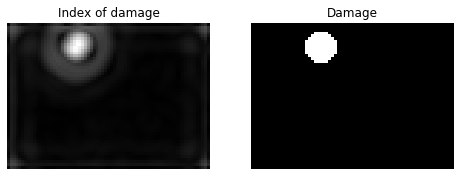

In [4]:
some_image = 701
plt.figure(figsize=(8,12))
plt.subplot(1,2,1)
plot_image(X_train[some_image])
plt.title('Index of damage')
plt.subplot(1,2,2)
plot_image(y_train[some_image])
plt.title('Damage')
plt.show()

## Data Preprocessing 

In this first study we will just subsample the data for a quick run and vectorize the matrices.

In [5]:
# Subsample the data for more efficient code execution in this exercise
num_test = 50
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
y_train = np.reshape(y_train, (y_train.shape[0], -1))
y_test = np.reshape(y_test, (y_test.shape[0], -1))
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(2400, 3621) (50, 3621)
(2400, 3621) (50, 3621)


Now, the data is ready to be passed trought a classifier. We will try to use the kNN to classify whether a pixel in an index image is part of the damage zone or not. Just remember that this classifier consist in two steps:
- It calculates the distance between the analized pixel and the training data.
- Then, it choose the label comparing with the k nearest neighbors.

As we want an output the same size of the image we implemented the kNN in a little different way to the typical one. We calculate the distance pixel-wise so at the end of the process each pixel in a test image has a distance to all the pixels in the same position of the training data. As you can imagine, this process is computational expensive that's why we use such a small amount of test data.

Note that this is one of the main problems of kNN. Since the trainig function is a constant process, the predict function computation grows as we increase the test set.

In [6]:
from classifiers.k_nearest_neighbor import KNearestNeighbor
knn_clf = KNearestNeighbor()
knn_clf.train(X_train, y_train)

dists = knn_clf.predict(X_test)
dists.shape

(50, 2400, 3621)

In [7]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).

y_pred = knn_clf.predict_labels(dists, k=1)

10 EPOCH
20 EPOCH
30 EPOCH
40 EPOCH
50 EPOCH


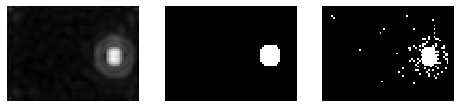

In [8]:
# Let's see the result of the 1-NN

some_image = 6
plt.figure(figsize=(8,12))
plt.subplot(1,3,1)
plot_image(np.reshape(X_test[some_image],(51,71)))
plt.subplot(1,3,2)
plot_image(np.reshape(y_test[some_image],(51,71)))
plt.subplot(1,3,3)
plot_image(np.reshape(y_pred[some_image],(51,71)))

To evaluate the performance of the classifier we will use the intersection over union value. This is defined by:
$$
IoU = \frac{TP}{FP+TP+FN}
$$

In [26]:
true_positive = np.sum(np.where(y_pred + y_test == 2, 1, 0), axis = 1)
false_positive = np.sum(np.where(y_pred - y_test == 1, 1, 0), axis = 1)
false_negative = np.sum(np.where(y_pred - y_test == -1, 1, 0), axis = 1)

iou = true_positive / (false_positive + true_positive + false_negative)
np.mean(iou)

0.19616831549245117

In [27]:
y_pred = knn_clf.predict_labels(dists, k=5)

10 EPOCH
20 EPOCH
30 EPOCH
40 EPOCH
50 EPOCH


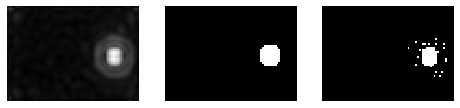

In [28]:
some_image = 6

plt.figure(figsize=(8,12))
plt.subplot(1,3,1)
plot_image(np.reshape(X_test[some_image],(51,71)))
plt.subplot(1,3,2)
plot_image(np.reshape(y_test[some_image],(51,71)))
plt.subplot(1,3,3)
plot_image(np.reshape(y_pred[some_image],(51,71)))

In [30]:
true_positive = np.sum(np.where(y_pred + y_test == 2, 1, 0), axis = 1)
false_positive = np.sum(np.where(y_pred - y_test == 1, 1, 0), axis = 1)
false_negative = np.sum(np.where(y_pred - y_test == -1, 1, 0), axis = 1)

iou = true_positive / (false_positive + true_positive + false_negative)
np.mean(iou)

0.2004428782401561

In [ ]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []

X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)

k_to_accuracies = {}

num_test_fold = X_train_folds[0].shape[0]
for k_value in k_choices:
    k_list = []
    for fold_index in range(num_folds): 
        # Train classifier
        val_set = X_train_folds.pop(fold_index)
        val_lbl = y_train_folds.pop(fold_index)
        X_fold = np.vstack(X_train_folds)
        y_fold = np.hstack(y_train_folds)
        classifier = KNearestNeighbor()
        classifier.train(X_fold, y_fold)
        
        # Calculate the accuracy
        y_test_pred = classifier.predict(val_set, k=k_value)
        true_positive = np.sum(np.where(y_pred + y_test == 2, 1, 0), axis = 1)
        false_positive = np.sum(np.where(y_pred - y_test == 1, 1, 0), axis = 1)
        false_negative = np.sum(np.where(y_pred - y_test == -1, 1, 0), axis = 1)

        iou = np.mean(true_positive / (false_positive + true_positive + false_negative))   
        k_list.append(iou)
        
        # Restore the varables
        X_train_folds = np.array_split(X_train, num_folds)
        y_train_folds = np.array_split(y_train, num_folds)
        
    k_to_accuracies[k_value] = k_list
    
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))